In [6]:
import numpy as np
from copy import deepcopy
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle

In [7]:
##Environment
class GridWorld:
    def __init__(self, height = 50, width = 50, n_c = 1, n_o = 1):
        self.wd = width
        self.ht = height
        self.n_c = n_c            # no. of classes
        self.n_o = n_o            # no. of objects  (n_c <= n_o)
        self.reward = [-1, 1]     # range of rewards
        self.start_coord = (0, 0)
        self.goal_coord = (height-1, width-1)
        self.x_g = height-1        # goal x-coord
        self.x_g = width-1         # goal y-coord
        self.r_g = 1               # goal reward
        self.D = 100 + n_o
        self.d = n_c + 1
        '''
        UP: 0
        RIGHT: 1
        DOWN: 2
        LEFT: 3
        '''
        self.actions = [0, 1, 2, 3]
        #self.x_s, self.y_s = self.start_coord

        self.object_coord = []
        self.object_class = []
        self.class_reward = {}
        self.objects_so_far = [0] * self.n_o

        self.generate_objects()    # Done once
        
        self.assign_classes()
        self.generate_class_reward()

    def generate_objects(self):
        n_o = self.n_o
        while n_o:
            object_x = np.random.randint(self.wd)
            object_y = np.random.randint(self.ht)
            if((object_x,object_y) not in self.object_coord):
                self.object_coord.append((object_x,object_y))
                n_o -= 1
  
    def assign_classes (self):
        self.object_class = np.random.randint(0, self.n_c, size = self.n_o)
 
    def generate_class_reward(self):
        for i in range(0, self.n_c):
            self.class_reward[i] = np.random.uniform(self.reward[0], self.reward[1])

    def reset(self):
        self.cur_pos_x, self.cur_pos_y = self.start_coord
        self.object_so_far = [0] * self.n_o
        self.generate_class_reward()
        return self.start_coord

    def render(self):
        for i in range(self.wd):
            for j in range(self.ht):
                if (i, j) in self.object_coord:
                    print(self.object_class[self.object_coord.index((i, j))], end = "")
                else:
                    print("*",end = "")
            print("")
            
    def show_class_rewards(self):
        print(self.class_reward)
    
    def restart(self):
        self.cur_pos_x, self.cur_pos_y = self.start_coord
        self.objects_so_far = [0] * self.n_o
        return self.start_coord
        
    def step(self, action):
        flag = 1
        reward = 0
        phi_at_step = [0] * (self.n_c + 1)
        done = False
        if action == 0 and self.cur_pos_y + 1 < self.ht:
            self.cur_pos_y += 1
        elif action == 1 and self.cur_pos_x + 1 < self.wd:
            self.cur_pos_x += 1
        elif action == 2 and self.cur_pos_y - 1 >=0:
            self.cur_pos_y -= 1
        elif action == 3 and self.cur_pos_x - 1 >=0:
            self.cur_pos_x -= 1
        
        pos = (self.cur_pos_x, self.cur_pos_y)
        if pos == self.goal_coord:
            phi_at_step[-1] = self.r_g
            done = True
            reward += 1
        elif pos in self.object_coord:
            object_index = self.object_coord.index(pos)
            if self.objects_so_far[object_index] == 0:
                phi_at_step[self.object_class[object_index]] = 1
                self.objects_so_far[object_index] = 1
                reward += self.class_reward[self.object_class[object_index]]

        return pos, np.array(phi_at_step), reward, done
               

In [8]:
class RadialBasis():

    def __init__(self, x_dim, y_dim, basis_x, basis_y):

        self.centres = []
        self.x_dim, self.y_dim = x_dim, y_dim
        for x in np.linspace(0, x_dim, basis_x):
            for y in np.linspace(0, y_dim, basis_y):
                self.centres.append((x/x_dim, y/y_dim))
      
    def getPositionVector(self, x, y):
        state = []
        x,y = x/self.x_dim, y/self.y_dim
        for cx, cy in self.centres:
            state.append(np.exp(-1 * ((cx - x)**2 + (cy - y)**2)/0.1))
        return np.array(state)

In [9]:
class SFQL:
    def __init__(self, env):
        self.env = env
        self.reward_weight_list = []
        self.Z_list = []
        self.eps_greedy = 0.15
        self.gamma = 0.95
        self.num_steps = 10000
        self.w_alpha = 0.01
        self.z_alpha = 0.01
        self.cum_reward_list = []
        self.rdb = RadialBasis(env.wd, env.ht, 10, 10)

    def featurize_state(self, state):
        return np.hstack((self.rdb.getPositionVector(state[0], state[1]), np.array(self.env.objects_so_far)))
    
    def find_best_psi(self, w_t, small_phi):
        max_k = 0
        action_val = -999999
        action_val_his = -999999
        for k in range(0,len(self.Z_list)):
            for action in self.env.actions: 
                psi = np.dot(small_phi.T, self.Z_list[k][action])
                new_action_val = np.dot(psi.T,w_t)
                action_val = max(action_val,new_action_val)
            max_k = k if (action_val > action_val_his) else max_k
            action_val_his = action_val
        
        return max_k 
                
    def get_action(self, small_phi, c, w_t):
        if np.random.uniform(0,1) < self.eps_greedy:   #In paper, Bernoulli is considered imstead of uniform
            return np.random.choice(self.env.actions)
        else:
            val_his = -99999
            act_choice = 0
            for action in self.env.actions:
                psi = np.dot(small_phi.T, self.Z_list[c][action])
                val = np.dot(psi.T,w_t)
                act_choice = action if val > val_his else act_choice
                val_his = max(val_his,val)
            return act_choice

    
    
    def algorithm(self,num_tasks):
        D = self.env.D
        d = self.env.d
        
        NUM_STEPS = self.num_steps
        
        #TODO: How to initialize the list? add before train or after train (only for the first task)
        
        Z = [np.random.rand(D,d) for r in range(len(self.env.actions))]
        
       
        for t in range(0, num_tasks):
            print("Task: ",t)
        
            w_t = np.random.rand(d)
            #print("Z = ",Z)
            self.Z_list.append(deepcopy(Z))
            self.reward_weight_list.append(deepcopy(w_t))
            Z = self.Z_list[-1]
            w_t = self.reward_weight_list[-1]
            env.reset()

            cum_reward = 0
            new_episode = True
            for ep in range(NUM_STEPS):
                if new_episode == True:
                    gamma = self.gamma
                    state = self.env.restart()
                    done = False
                    #creward = 0
                    new_episode = False
                
                small_phi = self.featurize_state(state)
                
                c = self.find_best_psi(w_t,small_phi)
                w_c = self.reward_weight_list[c]
                action = self.get_action(small_phi, c, w_t)
                s_prime, phi_at_step, reward, done = self.env.step(action)

                
                small_phi_prime = self.featurize_state(s_prime)

                if done:
                    gamma = 0
                    new_episode = True
                else:
                    c_prime = self.find_best_psi(w_t, small_phi_prime)
                    a_prime = self.get_action(small_phi_prime, c_prime, w_t)
                
                cum_reward += reward
                self.cum_reward_list.append(cum_reward)
                w_t = w_t + self.w_alpha * (reward - np.dot(phi_at_step.T, w_t)) * phi_at_step
                psi_prime = np.dot(small_phi_prime.T, self.Z_list[t][a_prime])
                psi = np.dot(small_phi.T, self.Z_list[t][action])
                z_t = self.Z_list[t][action]
                for k in range(0,d):
                    target_k = phi_at_step[k] + gamma*psi_prime[k]
                    z_t[:, k] = z_t[:, k] + self.z_alpha * (target_k - psi[k]) * small_phi

                if c != t:
                    a_prime = self.get_action(small_phi_prime, c, w_c)

                    psi_prime = np.dot(small_phi_prime.T, self.Z_list[c][a_prime])
                    psi = np.dot(small_phi.T, self.Z_list[c][action])
                    z_c = self.Z_list[c][action]
                    for k in range(0,d):
                        target_k = phi_at_step[k] + gamma*psi_prime[k]
                        z_c[:, k] = z_c[:, k] + self.z_alpha * (target_k - psi[k]) * small_phi_prime

                state = s_prime
                #print(round(cum_reward,4),end = " ")
            
            #mavg += creward
            print("Final",round(cum_reward,4))
        
        
        self.plot(cum_reward_list,num_tasks)
        return self.cum_reward_list
    
    def plot(self,cum_reward_list,num_talks):
        x_size = self.num_steps * num_talks
        x_axis = list(range(1,x_size+1))
        y_axis = cum_reward_list
        plt.plot(x_axis,y_axis)
        plt.xlabel("steps")
        plt.ylabel("cumulative reward")
        plt.title("SFQL")
        plt.legend()
        plt.show()

In [10]:
env = GridWorld(10, 10, 3, 10)
a = SFQL(env)
cum_reward_list = a.algorithm(250)

Task:  0
Final 2.099
Task:  1
Final -2.6517
Task:  2
Final 2.6768
Task:  3
Final 2.8431
Task:  4
Final 3.1532
Task:  5
Final 413.4747
Task:  6
Final -16.0555
Task:  7
Final 130.9488
Task:  8
Final 351.9132
Task:  9
Final 929.7668
Task:  10
Final 226.1541
Task:  11
Final 528.0516
Task:  12
Final 81.0458
Task:  13
Final 1041.2369
Task:  14
Final 1168.5481
Task:  15
Final -146.9941
Task:  16
Final -129.7261
Task:  17
Final 539.2174
Task:  18
Final 1165.4022
Task:  19
Final 0.5229
Task:  20
Final 4.3249
Task:  21
Final 285.4927
Task:  22
Final 320.5684
Task:  23
Final 515.6204
Task:  24
Final 103.4856
Task:  25
Final 291.8513
Task:  26
Final 1.3474
Task:  27
Final 459.8529
Task:  28
Final 57.4912
Task:  29
Final 8.102
Task:  30
Final 116.7863
Task:  31
Final 4.5696
Task:  32
Final 223.3636
Task:  33
Final 39.6099
Task:  34
Final 1.3425
Task:  35
Final 329.9644
Task:  36
Final 170.2756
Task:  37
Final 218.553
Task:  38
Final 12.7984
Task:  39
Final 810.2976
Task:  40
Final 15.0648
Task:  41

NameError: name 'cum_reward_list' is not defined

In [ ]:
file = open('cum_reward_list', 'wb')
pickle.dump(cum_reward_list, file)
file.close()

No handles with labels found to put in legend.


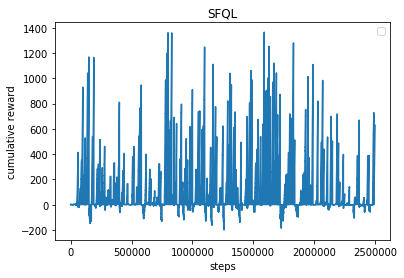

In [11]:
a.plot(a.cum_reward_list,250)